<h1 style='color: blue; font-size: 34px; font-weight: bold;'> Inferência de Negados
</h1>
<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> Este Notebook concentra um teste de estudo para Inferência de Negados em Risco de Crédito.  </i> 
</p>  

# <font color='red' style='font-size: 40px;'> Extrapolação   </font>
<hr style='border: 2px solid red;'>

> 1. Nessa técnica, desenvolvemos o modelo com os bons e maus aprovados pelo credor.
> 2. Filtramos os recusados que possuem restritivos muito fortes (casos de fraude, dois ou mais cheques sem fundo, etc...)
> 3. Os recusados sem restritivos, serão escorados pelo modelo, mas o ponto de corte deverá ser maior (se classificamos como bom um cliente com score > 0.5, o da amostra de recusados será 0.7, por exemplo)
> 4. Após a escoragem, juntaremos os aprovados e recusados e desenvolveremos um novo modelo.

# <font color='red' style='font-size: 40px;'> Parcelling   </font>
<hr style='border: 2px solid red;'>

> 1. Nessa técnica, desenvolvemos o modelo com bons e maus aprovados pelo credor.
> 2. Os recusados serão escorados pelo modelo
> 3. Segmentaremos os scores em decis, partindo da premissa de que indivíduos com o mesmo score seguem comportamentos muito parecidos
> 4. Calculamos a proporção de bons e maus dos aprovados dentro de cada decil
> 5. Para os rejeitados, atribuiremos a mesma proporção de bons e maus dos aprovados nos bons e maus dos rejeitados de maneira aleatória
> 6. Espera-se que a proporção de maus dentro dos recusados sejam maior que a dos aprovados, logo, na hora de adotarmos as proporções, é sempre interessante alterar brandamente o valor de modo que os recusados apresentem uma taxa maior de maus. Geralmente, essa taxa de deveria variar entre 2 a 4, a depender do rigor do modelo.
> 7. Rodamos o novo modelo considerando a nova distribuição de bons e maus.

# <font color='red' style='font-size: 40px;'> Library   </font>
<hr style='border: 2px solid red;'>

In [38]:
%pip install skopt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement skopt (from versions: none)
ERROR: No matching distribution found for skopt


In [43]:

## Bibliotecas de Análise de Dados
import pandas as pd 
import builtins as builtins
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import display, Image
from tabulate import tabulate
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

# Bibliotecas de Manipulação de Tempo
from datetime import datetime, date

## Bibliotecas de Modelagem Matemática e Estatística
import numpy as np
import scipy as sp 
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import normaltest, ttest_ind, ttest_rel, mannwhitneyu, wilcoxon, kruskal, uniform, chi2_contingency
from statsmodels.stats.weightstats import ztest
from numpy import interp
import random

# Bibliotecas de Seleção de Modelos
from skopt import BayesSearchCV

# Bibliotecas de Pré-Processamento e Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Bibliotecas de Modelos de Machine Learning
import joblib
from joblib import Parallel, delayed
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Bibliotecas de Métricas de Machine Learning
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, precision_recall_curve, average_precision_score, f1_score, log_loss, brier_score_loss, confusion_matrix, silhouette_score


# Parâmetros de Otimização
import random
import warnings
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100) 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings
# from pyspark.sql import SparkSession, Row 
# from pyspark.sql.functions import *
# import pyspark.sql.functions as F
 

# # Spark Session
# spark = SparkSession.builder.getOrCreate()

In [44]:
def plota_barras(lista_variaveis, df, titulo, rotation=0):        
    k = 0
    # Ordena os dados para garantir que as labels correspondam corretamente às barras
    df_sorted = df[lista_variaveis[k]].value_counts().index
    ax = sns.countplot(x=lista_variaveis[k], data=df, order=df_sorted, color='#1FB3E5')
    
    ax.set_title(f'{titulo}')
    ax.set_xlabel(f'{lista_variaveis[k]}', fontsize=14)
    ax.set_ylabel('Quantidade', fontsize=14)
    
    # Calcular o total para obter os percentuais
    total = sum([p.get_height() for p in ax.patches])
    
    sizes = []
    for bar in ax.patches:
        height = bar.get_height()
        sizes.append(height)
        ax.text(bar.get_x() + bar.get_width()/2,
                height,
                f'{builtins.round((height/total)*100, 2)}%',
                ha='center',
                fontsize=12
        )
    
    ax.set_ylim(0, max(sizes) * 1.1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right', fontsize=10)
    ax.set_yticklabels(['{:,.0f}'.format(y) for y in ax.get_yticks()], fontsize=10)

    plt.tight_layout()
    plt.show()

def plota_grafico_linhas(df, x, y, nao_calcula_media, title):

    if nao_calcula_media:
        # Criando o gráfico de linha
        plt.figure(figsize=(10, 6))
        plt.plot(df[x], df[y], marker='o', linestyle='-', color='#1FB3E5')

        # Adicionando títulos e rótulos aos eixos
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)

        for i, txt in enumerate(df[y]):
            plt.annotate(f'{txt:.1f}', (df[x][i], df[y][i]), textcoords="offset points", xytext=(0,1), ha='center')

        # Exibindo o gráfico
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        media = df[y].mean()
        # Criando o gráfico de linha
        plt.figure(figsize=(10, 6))
        plt.plot(df[x], df[y], marker='o', linestyle='-', color='#1FB3E5')

        # Adicionando linha da média
        plt.axhline(y=media, color='r', linestyle='--', linewidth=1, label=f'Média: {media:.2f}')
        plt.legend()

        # Adicionando títulos e rótulos aos eixos
        plt.title(title)
        plt.xlabel(x)
        plt.ylabel(y)

        for i, txt in enumerate(df[y]):
            plt.annotate(f'{txt:.1f}', (df[x][i], df[y][i]), textcoords="offset points", xytext=(0,1), ha='center')

        # Exibindo o gráfico
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

# <font color='red' style='font-size: 40px;'> Dataset </font>
<hr style='border: 2px solid red;'>


Medium with Problem's Description: https://python.plainenglish.io/a-project-on-reject-inference-94a6858bc821

Kaggle with Reject Inference's Dataset: https://www.kaggle.com/code/shraddhacodes/credit-card-default-reject-inference-project

Scorecard Example: https://medium.com/@shaunrobertcommee_37218/credit-risk-scoring-scorecard-application-07b58b77cbc8

1. ID (Identificador único)
    -   RK: Identificador único para o registro (ID).
2. Aprovado ou Negado (Variável alvo)
    - TGT_VAR: Variável alvo, que indica se o crédito foi aprovado (1) ou negado (0).
3. Variáveis do Cliente
    - GENDER: Gênero do cliente.
    - EDUCATION: Nível educacional do cliente (por exemplo, "GRA" para graduado).
    - ANNUAL_INCOME_AMT: Renda anual do cliente.
    - EMP_YR_CNT: Número de anos de emprego do cliente.
    - MARITAL_STATUS: Status civil do cliente (por exemplo, "MAR" para casado).
    - RESIDENCE: Tipo de residência do cliente (por exemplo, "COM" pode ser comercial).
    - EMPLOYMENT_STATUS_CD: Código do status de emprego (por exemplo, "N" pode indicar "não empregado").
    - APPL_PA_HHD_INC_AMT: Renda do domicílio ou familiar do cliente.
    - APPL_PA_LQD_AST_AMT: Valor dos ativos líquidos do cliente.
    - APPL_PA_AST_OTH_AMT: Valor de outros ativos do cliente que não são líquidos.
    - APPL_PA_BNKR_STS_CD: Status bancário do cliente, com "N" indicando que não há falência.
    - APPL_PA_LEG_JUDG_FLG: Indicador de se o cliente tem algum julgamento legal relacionado a dívidas.
4. Variáveis de Limite
    - APPL_SCR_NO: Número da pontuação ou avaliação de crédito do cliente.
    - APPL_APPT_MAX_AGE_NO: Idade máxima permitida para a solicitação de crédito.
    - APPL_APPT_MAX_LBL_AMT: Limite máximo permitido para a solicitação de crédito.
    - ACC_APPL_PCL_VAL_AMT: Valor de parcelamento solicitado ou realizado.
    - APPL_PCL_TYP_CD: Código do tipo de parcelamento solicitado.
    - ACC_AMT: Valor total da conta ou limite de crédito.
5. Variáveis de Crédito
    - TAX_CODE: Código relacionado ao tipo de imposto ou categoria tributária do cliente.
    - AMT: Valor total de alguma transação ou crédito.
    - ACC_1_30DLQ_LST_3M_CNT: Contagem de contas com atraso de 1 a 30 dias nos últimos 3 meses.
    - ACC_31_60DLQ_LST_3M_CNT: Contagem de contas com atraso de 31 a 60 dias nos últimos 3 meses.
    - ACC_61_90DLQ_LST_3M_CNT: Contagem de contas com atraso de 61 a 90 dias nos últimos 3 meses.
    - ACC_91_120DLQ_LST_3M_CNT: Contagem de contas com atraso de 91 a 120 dias nos últimos 3 meses.
    - ACC_DLD_PAY_LST_3M_CNT: Contagem de contas com pagamento de dívida nos últimos 3 meses.
    - ACC_1_30DLQ_LST_3M_AMT: Valor total de contas com atraso de 1 a 30 dias nos últimos 3 meses.
    - TOT_OUTSTANDING_31_60_DAY_AMT: Valor total de dívidas pendentes de 31 a 60 dias.
    - ACC_61_90DLQ_LST_3M_AMT: Valor total de contas com atraso de 61 a 90 dias nos últimos 3 meses.
    - ACC_91_120DLQ_LST_3M_AMT: Valor total de contas com atraso de 91 a 120 dias nos últimos 3 meses.
    - SLN_DR_TRNS_LST_3M_CNT: Contagem de transações de débito realizadas nos últimos 3 meses.
    - APPL_PA_REST_AMT: Valor restante de alguma dívida ou compromisso financeiro.
    - APPL_PA_LBL_REST_AMT: Saldo restante de algum débito ou empréstimo de longo prazo.
    - APPL_PA_MNTS_FLG: Indicador de mensalidade ou parcelamento do cliente.
    - APPL_PA_BUR1_BNKP_CNT: Contagem de falências no primeiro nível (ou fase) do cliente.
    - APPL_PA_BUR2_BNKP_CNT: Contagem de falências no segundo nível (ou fase) do cliente.
    - APPL_PA_BUR1_CURR_LMT_AMT: Limite de crédito atual relacionado ao primeiro nível de falência.

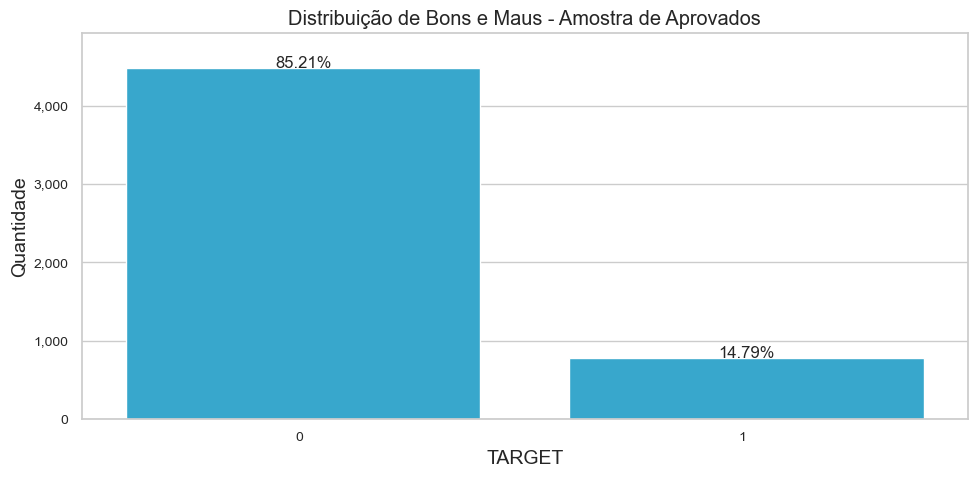

In [49]:
df_aprovado = pd.read_excel('../data/appbeh_approved.xlsx')
df_aprovado['APPROVED'] = 1
df_rejeitado = pd.read_excel('../data/appbeh_rej.xlsx')
df_rejeitado['APPROVED'] = 0

novo_nome_colunas = {
    # ID
    'RK': 'ID_Registro',
    # APROVADO OU NEGADO
    'APPROVED': 'APROVADO',
    # BOM OU RUIM
    'TGT_VAR': 'TARGET',
    # VARIÁVEIS CLIENTES
    'GENDER': 'Genero_Cliente',
    'EDUCATION': 'Nivel_Educacional_Cliente',
    'ANNUAL_INCOME_AMT': 'Renda_Anual_Cliente',
    'EMP_YR_CNT': 'Anos_Experiencia_Emprego',
    'MARITAL_STATUS': 'Status_Civil_Cliente',
    'RESIDENCE': 'Tipo_Residencia_Cliente',
    'EMPLOYMENT_STATUS_CD': 'Status_Contratual_Cliente',
    'APPL_PA_HHD_INC_AMT': 'Renda_Domiciliar_Cliente',
    'APPL_PA_LQD_AST_AMT': 'Valor_Ativos_Liquidos_Cliente',
    'APPL_PA_AST_OTH_AMT': 'Valor_Outros_Ativos_Cliente',
    'APPL_PA_BNKR_STS_CD': 'Status_Bancario_Cliente',
    'APPL_PA_LEG_JUDG_FLG': 'Presenca_Julgamento_Legal_Cliente',
    'APPL_SCR_NO': 'Pontuacao_Credito_Cliente',
    'APPL_APPT_MAX_AGE_NO': 'Idade_Maxima_Para_Aplicacao',
    'APPL_APPT_MAX_LBL_AMT': 'Limite_Maximo_Aplicacao_Credito',
    'ACC_AMT': 'Valor_Limite_Conta_Credito',

    # VARIÁVEIS DE CRÉDITO
    'TAX_CODE': 'Codigo_Tipo_Imposto_Cliente',
    'AMT': 'Valor_Total_Transacao_Credito',
    'ACC_1_30DLQ_LST_3M_CNT': 'Numero_Contas_1_30_Dias_Atraso_3M',
    'ACC_DLD_PAY_LST_3M_CNT': 'Numero_Contas_Pagamento_Divida_3M',
    'ACC_1_30DLQ_LST_3M_AMT': 'Valor_Contas_1_30_Dias_Atraso_3M',
    'SLN_DR_TRNS_LST_3M_CNT': 'Numero_Transacoes_Debito_3M',
    'APPL_PA_REST_AMT': 'Valor_Restante_Obrigacoes_Cliente',
    'APPL_PA_LBL_REST_AMT': 'Saldo_Restante_Obrigacoes_LongPrazo',
    'APPL_PA_MNTS_FLG': 'Indicador_Parcelamento_Mensal',
    'ACC_APPL_PCL_VAL_AMT': 'Valor_Parcelamento_Solicitado',
    'APPL_PCL_TYP_CD': 'Tipo_Parcelamento_Solicitado',
    'APPL_PA_BUR1_BNKP_CNT': 'Numero_Falencias_Fase_1_Cliente',
    'APPL_PA_BUR2_BNKP_CNT': 'Numero_Falencias_Fase_2_Cliente',
    'APPL_PA_BUR1_CURR_LMT_AMT': 'Limite_Atual_Falencia_Fase_1'
}

variaveis = [
    # Identificação
    "ID_Registro",

    # Status de aprovação
    'APROVADO',

    # BOM OU MAU
    "TARGET",

    # Variáveis de clientes
    "Genero_Cliente",
    "Nivel_Educacional_Cliente",
    "Renda_Anual_Cliente",
    "Anos_Experiencia_Emprego",
    "Status_Civil_Cliente",
    "Tipo_Residencia_Cliente",
    "Status_Contratual_Cliente",
    "Renda_Domiciliar_Cliente",
    "Valor_Ativos_Liquidos_Cliente",
    "Valor_Outros_Ativos_Cliente",
    "Status_Bancario_Cliente",
    "Presenca_Julgamento_Legal_Cliente",
    "Pontuacao_Credito_Cliente",
    "Idade_Maxima_Para_Aplicacao",
    "Limite_Maximo_Aplicacao_Credito",
    "Valor_Limite_Conta_Credito",

    # Variáveis de crédito
    "Codigo_Tipo_Imposto_Cliente",
    "Valor_Total_Transacao_Credito",
    "Numero_Contas_1_30_Dias_Atraso_3M",
    "Valor_Contas_1_30_Dias_Atraso_3M",
    "Indicador_Parcelamento_Mensal",
    "Valor_Parcelamento_Solicitado",
    "Tipo_Parcelamento_Solicitado",
    "Numero_Falencias_Fase_1_Cliente",
    "Numero_Falencias_Fase_2_Cliente",
    "Limite_Atual_Falencia_Fase_1"
]


# Usando o método .rename() para renomear as colunas
df_aprovado = df_aprovado.rename(columns=novo_nome_colunas)
df_aprovado = df_aprovado[variaveis].sort_values(by = 'ID_Registro', ascending = True)

df_rejeitado = df_rejeitado.rename(columns=novo_nome_colunas)
df_rejeitado = df_rejeitado[variaveis].sort_values(by = 'ID_Registro', ascending = True)


# Distribuição de Bons e Maus
plota_barras(['TARGET'], df_aprovado, f'Distribuição de Bons e Maus - Amostra de Aprovados', 0)


In [51]:
df_aprovado.TARGET.value_counts()

TARGET
0    4475
1     777
Name: count, dtype: int64

In [52]:
df_rejeitado.TARGET.value_counts()

TARGET
0    4026
1     723
Name: count, dtype: int64

In [54]:
teste = df_aprovado.merge(df_rejeitado, on = 'ID_Registro', how = 'inner')

In [55]:
teste

,ID_Registro,APROVADO_x,TARGET_x,Genero_Cliente_x,Nivel_Educacional_Cliente_x,Renda_Anual_Cliente_x,Anos_Experiencia_Emprego_x,Status_Civil_Cliente_x,Tipo_Residencia_Cliente_x,Status_Contratual_Cliente_x,Renda_Domiciliar_Cliente_x,Valor_Ativos_Liquidos_Cliente_x,Valor_Outros_Ativos_Cliente_x,Status_Bancario_Cliente_x,Presenca_Julgamento_Legal_Cliente_x,Pontuacao_Credito_Cliente_x,Idade_Maxima_Para_Aplicacao_x,Limite_Maximo_Aplicacao_Credito_x,Valor_Limite_Conta_Credito_x,Codigo_Tipo_Imposto_Cliente_x,Valor_Total_Transacao_Credito_x,Numero_Contas_1_30_Dias_Atraso_3M_x,Valor_Contas_1_30_Dias_Atraso_3M_x,Indicador_Parcelamento_Mensal_x,Valor_Parcelamento_Solicitado_x,Tipo_Parcelamento_Solicitado_x,Numero_Falencias_Fase_1_Cliente_x,Numero_Falencias_Fase_2_Cliente_x,Limite_Atual_Falencia_Fase_1_x,APROVADO_y,TARGET_y,Genero_Cliente_y,Nivel_Educacional_Cliente_y,Renda_Anual_Cliente_y,Anos_Experiencia_Emprego_y,Status_Civil_Cliente_y,Tipo_Residencia_Cliente_y,Status_Contratual_Cliente_y,Renda_Domiciliar_Cliente_y,Valor_Ativos_Liquidos_Cliente_y,Valor_Outros_Ativos_Cliente_y,Status_Bancario_Cliente_y,Presenca_Julgamento_Legal_Cliente_y,Pontuacao_Credito_Cliente_y,Idade_Maxima_Para_Aplicacao_y,Limite_Maximo_Aplicacao_Credito_y,Valor_Limite_Conta_Credito_y,Codigo_Tipo_Imposto_Cliente_y,Valor_Total_Transacao_Credito_y,Numero_Contas_1_30_Dias_Atraso_3M_y,Valor_Contas_1_30_Dias_Atraso_3M_y,Indicador_Parcelamento_Mensal_y,Valor_Parcelamento_Solicitado_y,Tipo_Parcelamento_Solicitado_y,Numero_Falencias_Fase_1_Cliente_y,Numero_Falencias_Fase_2_Cliente_y,Limite_Atual_Falencia_Fase_1_y
